# Experiments with LogRegression

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd
from tqdm import tqdm

In [12]:
def to_seconds(time):
    return time.microseconds * 1e-6 + time.seconds

def f(w, X, y):
    res = 0
    for i in range(X.shape[0]):
        res += np.log(1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def grad_f(w, X, y):
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]
def grad_grad_f(w, X, y):
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += - (X[i] * y[i])**2 * np.exp(- 2*w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))**2 \
               + (X[i] * y[i])**2 * np.exp(- 2*w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

In [3]:
class Model:
    def __init__(self, d):
        self.d = d
        self.w = np.zeros(d)

        self.converge = []

        self.write_time = False
        self.times = []
        self.operations = []
        self.operations_done = 0
        self.label = ""

        self.D_ts = []
    
    def reset(self):
        self.w = np.ones(self.d)
        self.converge = []
        self.times = []
        self.D_ts = []
        self.operations = []
        self.operations_done = 0

    def AdamL2(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8]):
        self.reset()
        self.label = "Regularized Adam"

        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        grad = np.ones(self.d)
        for i in tqdm(range(steps)):
            grad = grad_f(self.w, X, y) + weight_decay * self.w
            
            self.converge.append(np.linalg.norm(grad))

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps)

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

    def AdamL2(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8]):
        self.reset()
        self.label = "Regularized Adam"

        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        grad = np.ones(self.d)
        for i in tqdm(range(steps)):
            grad = grad_f(self.w, X, y) + weight_decay * self.w
            
            self.converge.append(np.linalg.norm(grad))

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps)

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

    def AdamW(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, special_convergence=False, params=[0.99, 0.999, 1e-8]):
        self.reset()
        self.label = "AdamW"
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        grad = np.ones(self.d)
        for i in tqdm(range(steps)):
            grad = grad_f(self.w, X, y)

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            if special_convergence:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay * (np.sqrt(v_bias_corr) + eps)))
            else:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps) - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)
    def OASISW(self, X, y, steps=2000, learning_rate=1e-3, weight_decay=0, special_convergence=False, params=[0.99, 0.999, 1e-8]):
        
    def AdamWBA(self, X, y, steps=200, batch_adaption_size=10, batch_type="random", learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8], variance_reduction=False):
        self.reset()
        self.label = "AdamW: type " + batch_type + f", size={batch_adaption_size}" + (" VR" if variance_reduction else "")
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)
        v_bias_corr = np.zeros(self.d)
        Dt_summ = np.zeros(self.d)

        if self.write_time:
            self.time_start = dt.now()

        for i in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
        
            self.converge.append(np.linalg.norm(grad))

            adaption_indexes = []
            if i == 0:
                adaption_indexes = range(self.d)
            elif batch_type == "random":
                adaption_indexes = np.random.choice(self.d, size=(batch_adaption_size,), replace=False)
            # elif batch_type == "max":
            #     adaption_indexes = np.argsort(v_bias_corr)[-batch_adaption_size:]
            # elif batch_type == "mean":
            #     adaption_indexes = np.argsort(v_bias_corr)[(self.d  - batch_adaption_size) // 2: (self.d + batch_adaption_size) // 2]

            m = beta1 * m + (1 - beta1) * grad
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            if variance_reduction:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))

                Dt_summ += (np.sqrt(v_bias_corr) + eps)
                Dt = Dt_summ / (i + 1)
            else:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))
                Dt = (np.sqrt(v_bias_corr) + eps)

            self.w = self.w - learning_rate * m_bias_corr / Dt
            self.w = self.w - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

            self.operations.append(self.operations_done)
            self.operations_done += batch_adaption_size
    
    def AdamLIKE(self, X, y, steps=200, typ="SEGA", batch_adaption_size=10, learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8]):
        pass

    def GD(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0):
        self.reset()
        self.label = "GD"

        if self.write_time:
            self.time_start = dt.now()

        for _ in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
            grad = grad + weight_decay * self.w

            self.w = self.w - learning_rate * grad
            self.converge.append(np.linalg.norm(grad))

    def get_converge_iteration(self):
        x_plot = range(len(self.converge))
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_converge_operations(self):
        x_plot = self.operations
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_D_t(self):
        return self.D_ts

## Mushrooms

In [4]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = y * 2 - 3
n, d = X.shape
print("n = {}, d = {}".format(n, d))

n = 8124, d = 112


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
from sklearn import preprocessing

In [7]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_train)

# AdamW does not converge

In [14]:
steps = 1000
params = (0.99, 0.99, 1e-8)

M1 = Model(d)
M1.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot1, y_plot1 = M1.get_converge_iteration()

M2 = Model(d)
M2.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot2, y_plot2 = M2.get_converge_iteration()

100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


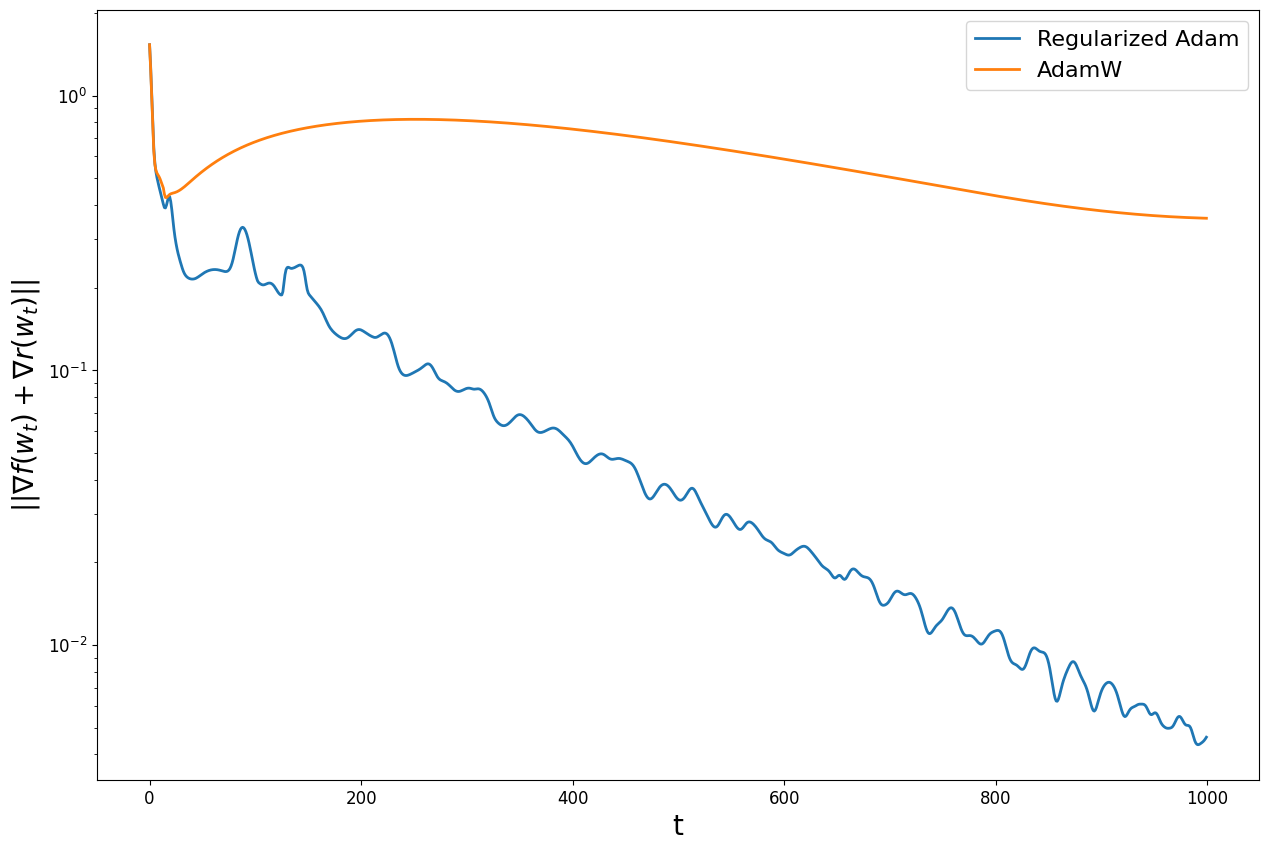

In [10]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel("Error logarithm"
#plt.ylabel(r'$||\nabla f(w_t) + \nabla r(w_t)||$')


plt.semilogy(x_plot1, y_plot1, linewidth=linewidth, label=r"AdamL2 $[\nabla f + \\nabla r")

#M.AdamSW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
#x_plot, y_plot = M.get_converge_iteration()
#plt.semilogy(x_plot, y_plot, linewidth=linewidth, label=M.label)


plt.semilogy(x_plot2, y_plot2, linewidth=linewidth, label=M2.label)

plt.legend()

# plt.savefig("/fig1.jpg")
plt.show()

# Special conveergence

100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


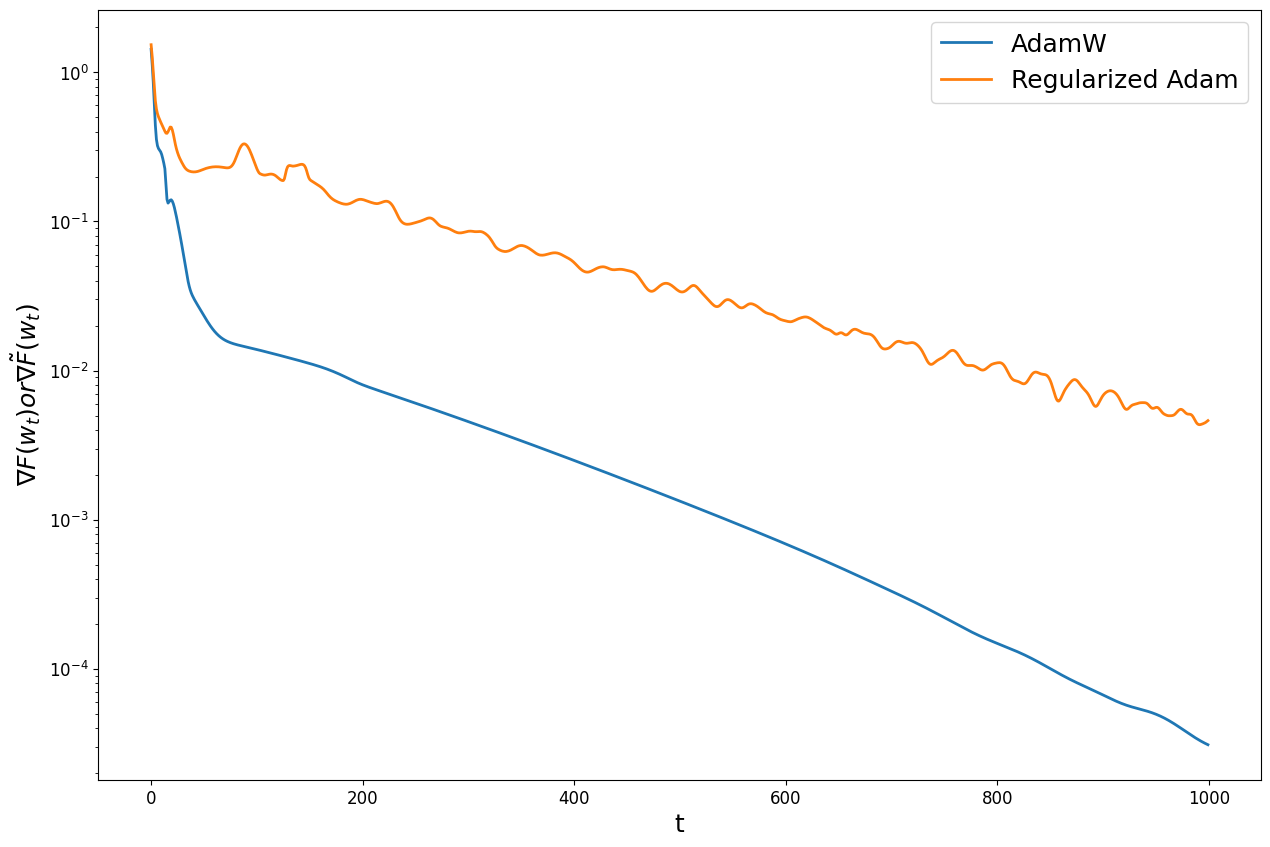

In [9]:
steps = 1000
params = (0.99, 0.99, 1e-8)

M = Model(d)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("t", fontsize=font)
plt.ylabel(r'$\nabla F(w_t) or \nabla \tilde{F}(w_t)$', fontsize=font)

M.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params, special_convergence=True)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, linewidth=linewidth, label=M.label)

M.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, linewidth=linewidth, label=M.label)

plt.legend(fontsize=font)

# plt.savefig("/fig1.jpg")
plt.show()

## Adaptive matrix $D_t$ investigation

In [ ]:
M.AdamW(X, y, weight_decay=0.1, learning_rate=0.1)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)
D_ts = M.get_D_t()

M.GD(X, y)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)

M.AdamL2(X, y, weight_decay=0.1, learning_rate=0.1)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)

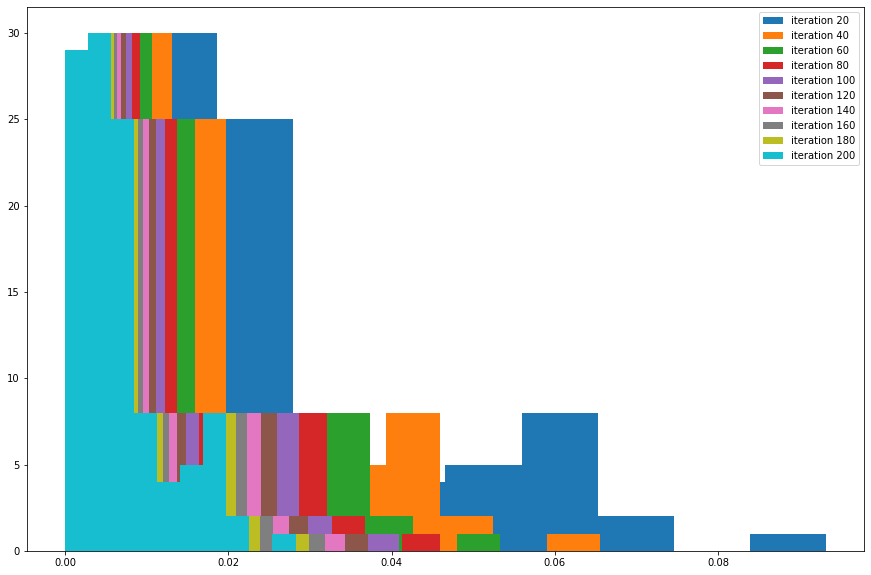

In [85]:
fig = plt.figure(figsize=(15, 10))
for i in range(19, 200, 20):
    plt.hist(D_ts[i], label=f"iteration {i + 1}")
plt.legend()